In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import altair as alt

In [2]:
%matplotlib inline

In [3]:
# Import call data and report data and create df's

data = pd.read_csv("/Users/Stacy/Documents/WebDevelopment/projects/SPD/sexualAssault_datasets/2010-2018_sexcrimes_violentcrimes.csv", index_col="CAD Event Number")
data = pd.DataFrame(data)

report_data = pd.read_csv('/Users/Stacy/Documents/WebDevelopment/projects/SPD/sexualAssault_datasets/2010-2018_Crime_Data.csv', index_col='Report Number')
report_data = pd.DataFrame(report_data)

In [4]:
# Rename columns to be pythonic

data.columns = ['event_clearing', 'call_type', 'priority', 
                'initial_call_type', 'final_call_type', 'original_time_queued',
               'arrived_time', 'precinct', 'sector', 'beat']

report_data.columns = ['event_date', 'event_time', 'report_date',
                       'report_time','crime_subcategory', 'primary_offense_descript',
                       'precinct', 'sector', 'beat', 'neighborhood']

In [5]:
# ID all calls cancelled by dispatch

cancelled_calls = data[data.event_clearing.str.contains("CANCELLED")]

# Delete rows with cxl'd calls

data = data[data.event_clearing != 'RESPONDING UNIT(S) CANCELLED BY RADIO']
data = data[data.event_clearing != 'DUPLICATED OR CANCELLED BY RADIO']

#### Clean time values

In [6]:
report_data.dtypes

event_date                  object
event_time                   int64
report_date                 object
report_time                  int64
crime_subcategory           object
primary_offense_descript    object
precinct                    object
sector                      object
beat                        object
neighborhood                object
dtype: object

In [7]:
report_data.head()

,event_date,event_time,report_date,report_time,crime_subcategory,primary_offense_descript,precinct,sector,beat,neighborhood
Report Number,,,,,,,,,,
20100000100029,03/27/2010,239,03/27/2010,310,NARCOTIC,NARC-POSSESS-HALLUCINOGEN,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
20100000100052,03/27/2010,1,03/27/2010,501,CAR PROWL,THEFT-CARPROWL,WEST,K,K1,DOWNTOWN COMMERCIAL
20100000100057,03/27/2010,348,03/27/2010,402,DUI,DUI-LIQUOR,UNKNOWN,NaN,NaN,UNKNOWN
20100000100076,03/27/2010,300,03/27/2010,450,ROBBERY-STREET,ROBBERY-STREET-BODYFORCE,NORTH,B,B3,WALLINGFORD
20100000100104,03/27/2010,508,03/27/2010,508,DUI,DUI-DRUGS,EAST,E,E1,CAPITOL HILL


In [8]:
# Change event_date and report_date to datetime
report_data['event_date'] = pd.to_datetime(report_data.event_date)
report_data['report_date'] = pd.to_datetime(report_data.report_date)

# Change event_time and report_time to datetime
report_data['event_time'] = pd.to_datetime(report_data.event_time, unit='s')
report_data['report_time'] = pd.to_datetime(report_data.report_time, unit='s')

# report_data['event_time'] = pd.to_datetime(report_data.event_time, format='%H:%M').dt.time
# report_data['report_time'] = pd.to_datetime(report_data.report_time, format='%H:%M').dt.time




In [9]:
# Change original_time_queued to datetime
data['original_time_queued'] = pd.to_datetime(data.original_time_queued)

# Change arrived_time to datetime
data['arrived_time'] = pd.to_datetime(data.arrived_time, format='%b %d %Y %I:%M:%S:%f%p')

# Add time delta between original_time_queued and arrived_time
data['time_delta'] = ((data.arrived_time - data.original_time_queued)/np.timedelta64(1, 's')).astype(int)

In [10]:
# Add columns for arrived year and month
data['year'] = data.arrived_time.dt.year
data['month'] = data.arrived_time.dt.month

# Where arrive_time year = 1900, change data.year and data.month to original_time_queued year
mask = data.year < 1901
column_name_year = 'year'
column_name_month = 'month'
data.loc[mask, column_name_year] = data.original_time_queued.dt.year
data.loc[mask, column_name_month] = data.original_time_queued.dt.month

In [11]:
report_data.head()

,event_date,event_time,report_date,report_time,crime_subcategory,primary_offense_descript,precinct,sector,beat,neighborhood
Report Number,,,,,,,,,,
20100000100029,2010-03-27,1970-01-01 00:03:59,2010-03-27,1970-01-01 00:05:10,NARCOTIC,NARC-POSSESS-HALLUCINOGEN,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
20100000100052,2010-03-27,1970-01-01 00:00:01,2010-03-27,1970-01-01 00:08:21,CAR PROWL,THEFT-CARPROWL,WEST,K,K1,DOWNTOWN COMMERCIAL
20100000100057,2010-03-27,1970-01-01 00:05:48,2010-03-27,1970-01-01 00:06:42,DUI,DUI-LIQUOR,UNKNOWN,NaN,NaN,UNKNOWN
20100000100076,2010-03-27,1970-01-01 00:05:00,2010-03-27,1970-01-01 00:07:30,ROBBERY-STREET,ROBBERY-STREET-BODYFORCE,NORTH,B,B3,WALLINGFORD
20100000100104,2010-03-27,1970-01-01 00:08:28,2010-03-27,1970-01-01 00:08:28,DUI,DUI-DRUGS,EAST,E,E1,CAPITOL HILL


#### Define terms

In [12]:
# Define TRU initial call types
TRU_call_types = [
    'TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS)',
    'TRU - RAPE',
    'TRU - LEWD CONDUCT',
    'TRU - CHILD ABUSED, NEGLECTED',
    'TRU - THREATS',
    'TRU - ROBBERY',
    'TRU - ASLT - MOLESTED ADULT (GROPED, FONDLED, ETC)',
    'TRU - HARASSMENT',
    'TRU - SEX IN PUBLIC',
    'TRU - THEFT',
    'TRU - FOLLOW UP',
    'TRU - MVC - HIT AND RUN',
    'TRU - LURING',
    'TRU - FORGERY/CHKS/BUNCO/SCAMS/ID THEFT',
    'TRU - SUSPICIOUS CIRCUMSTANCES']

In [13]:
# Define terms that ID which crime_type

# Define terms that ID rape CFS
rape_terms = 'Stranger|Acquaintance'
rape_call_types = [
    'Acquaintance Rape',
    'Stranger Rape']
    #'--RAPE - KNOWN SUSPECT (ACQUAINTANCE)',
    #'--RAPE - UNKNOWN SUSPECT (STRANGER)']

# Define terms that ID sex crimes
sex_crime_terms = 'CSEC|Lewd|Molesting|Stranger|Acquaintance'
sex_crime_call_types = [
    'Lewd Conduct',
    'Acquaintance Rape',
    'Stranger Rape',
    'Molesting',
    'CSEC']
   # '--SEX OFFENSES (NON-RAPE) - LEWD CONDUCT',
    #'--RAPE - KNOWN SUSPECT (ACQUAINTANCE)',
    #'--RAPE - UNKNOWN SUSPECT (STRANGER)',
    #'--SEX OFFENSES (RAPE) - MOLESTING',
    #'--COMMERCIAL SEXUAL EXPLOITATION OF MINORS (CSEC)']

# Define terms that ID other violent crimes
violent_crime_terms = 'Kidnap|Homicide|Shooting|Assault|Robbery'
violent_crime_call_types = [
    '--ASSAULTS - FIREARM INVOLVED',
    '--ROBBERY - ARMED',
    '--HOMICIDE',
    '--KIDNAP - GENERAL',
    '--DRIVE BY SHOOTING - NO INJURIES']

In [14]:
# Replace final_call_type values to english
# DRY this. oof.

# Seriously. Look at this. oof.

data['final_call_type'] = data['final_call_type'].replace("--HOMICIDE", "Homicide")
data['final_call_type'] = data['final_call_type'].replace("--ASSAULTS - FIREARM INVOLVED", "Assault w/ Firearm")
data['final_call_type'] = data['final_call_type'].replace("--ROBBERY - ARMED", "Armed Robbery")
data['final_call_type'] = data['final_call_type'].replace("--KIDNAP - GENERAL", "Kidnap")
data['final_call_type'] = data['final_call_type'].replace("--DRIVE BY SHOOTING - NO INJURIES", "Drive-by Shooting")
data['final_call_type'] = data['final_call_type'].replace("--SEX OFFENSES (NON-RAPE) - LEWD CONDUCT", "Lewd Conduct")
data['final_call_type'] = data['final_call_type'].replace("--RAPE - KNOWN SUSPECT (ACQUAINTANCE)", "Acquaintance Rape")
data['final_call_type'] = data['final_call_type'].replace("--RAPE - UNKNOWN SUSPECT (STRANGER)", "Stranger Rape")
data['final_call_type'] = data['final_call_type'].replace("--SEX OFFENSES (RAPE) - MOLESTING", "Molesting")
data['final_call_type'] = data['final_call_type'].replace("--COMMERCIAL SEXUAL EXPLOITATION OF MINORS (CSEC)", "CSEC")

# Replace precinct names with lowercase
data['precinct'] = data['precinct'].replace('NORTH', 'North')
data['precinct'] = data['precinct'].replace('EAST', 'East')
data['precinct'] = data['precinct'].replace('SOUTH', 'South')
data['precinct'] = data['precinct'].replace('WEST', 'West')
data['precinct'] = data['precinct'].replace('SOUTHWEST', 'Southwest')
data['precinct'] = data['precinct'].replace('UNKNOWN', 'Unknown')

In [15]:
# Define clearing codes for is_arrest

arrest_cc = ['PHYSICAL ARREST MADE']

#### Add columns for is_arrest, is_TRU, crime_type

In [16]:
# Add column identifying if there was an arrest
data['is_arrest'] = np.where(data['event_clearing'].isin(arrest_cc), 'yes', 'no')

# Add column identifying if this was A TRU call
data['is_TRU'] = np.where(data['initial_call_type'].isin(TRU_call_types), 'yes', 'no')

In [17]:
# Add crime_type for each call type as a violent crime, sex crime or rape
is_rape = data['final_call_type'].str.contains(rape_terms)
is_vc = data['final_call_type'].str.contains(violent_crime_terms)
is_sex_crime = data['final_call_type'].str.contains(sex_crime_terms)
is_lewd_conduct = data['final_call_type'].str.contains("Lewd")
is_arrest_mask = data['is_arrest'] == "yes"
is_tru_mask = data['is_TRU'] == "yes"

data['crime_type'] = np.where(data['final_call_type'].isin(rape_call_types), 'rape',
                                (np.where(data['final_call_type'].isin(sex_crime_call_types),
                                          'other sex crime', 'violent crime')))

In [44]:
data.head()

,event_clearing,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct,sector,beat,time_delta,year,month,is_arrest,is_TRU,crime_type
CAD Event Number,,,,,,,,,,,,,,,,
2010000066820,ASSISTANCE RENDERED,911,2,MENTAL - PERSON OR PICKUP/TRANSPORT,Lewd Conduct,2010-02-27 22:54:25,2010-02-27 22:55:45,North,UNION,U1,80,2010,2,no,no,other sex crime
2010000000327,PHYSICAL ARREST MADE,911,1,ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS),Assault w/ Firearm,2010-01-01 03:13:06,2010-01-01 03:14:51,South,ROBERT,R3,105,2010,1,yes,no,violent crime
2010000000451,REPORT WRITTEN (NO ARREST),911,2,THEFT OF SERVICES,Armed Robbery,2010-01-01 05:46:54,2010-01-01 06:39:35,North,UNION,U1,3161,2010,1,no,no,violent crime
2010000000466,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",3,RAPE,Acquaintance Rape,2010-01-01 06:28:49,2010-01-01 06:40:09,East,GEORGE,G1,680,2010,1,no,no,rape
2010000000776,REPORT WRITTEN (NO ARREST),911,3,RAPE,Acquaintance Rape,2010-01-01 15:05:57,2010-01-01 15:12:26,Southwest,FRANK,F3,389,2010,1,no,no,rape


## 3. TRU Calls


In [23]:
# Create crosstab to view % all TRU calls by crime type

percentage_tru_calls = pd.crosstab(data.final_call_type,data.is_TRU,
                          normalize = 'index').rename_axis(None)



percentage_tru_calls

is_TRU,no,yes
Acquaintance Rape,0.975972,0.024028
Armed Robbery,0.999149,0.000851
Assault w/ Firearm,0.990256,0.009744
CSEC,0.980769,0.019231
Drive-by Shooting,0.999125,0.000875
Homicide,1.000000,0.000000
Kidnap,0.989899,0.010101
Lewd Conduct,0.990761,0.009239
Molesting,0.971763,0.028237
Stranger Rape,0.986559,0.013441


Sex crimes where there is a victim, are initially sent to TRU at higher rates than other violent crimes. For the nine years of police calls examined, non-sex-related violent crimes sent to TRU averaged less than 1% of the time. In the same time period, 2.4% of calls reporting acquaintance rape and 2.8% of molestation were sent to TRU.

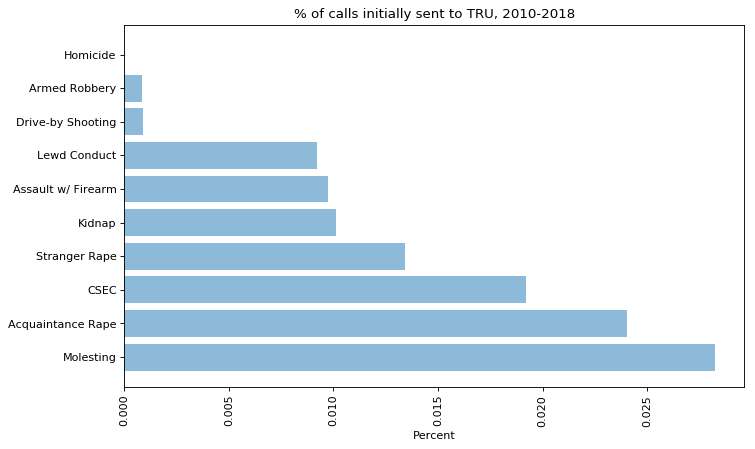

In [24]:
# Plot TRU call percentages as bar graph. 

percentage_tru_sorted = percentage_tru_calls.sort_values('yes',ascending=False)

plt.figure(figsize=(10,6), dpi= 80)
plt.barh(percentage_tru_sorted.index, percentage_tru_sorted.yes, align='center', alpha=0.5)
plt.xlabel('Percent')
plt.title('% of calls initially sent to TRU, 2010-2018')
plt.xticks(rotation=90)

plt.show()

An average of 2.8% of the calls reporting molesting were sent to TRU. 

Even though the overall number of rape calls initially sent to the Telephone Reporting Unit is low, it still means that 75 people called the Seattle Police Department to report a rape and were directed to the same police unit that would handle a call reporting a bicycle that was stolen two years ago.

Between 2010 and 2018, 55 acquaintance rape calls, 20 stranger rape calls and 41 molesting calls were referred to TRU.

**Insert viz showing number of rape and molesting calls sent to TRU**

tutorial: https://pudding.cool/process/flexbox-layout/

In [60]:
# Sandbox to confirm number of TRU molesting and rape calls

data_tru_df = data[is_tru_mask]
# data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains("Molesting")]
# data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains("Acquaintance")]
data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains("Stranger")]
# data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains('Rape')]

data_tru_df

,event_clearing,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct,sector,beat,time_delta,year,month,is_arrest,is_TRU,crime_type
CAD Event Number,,,,,,,,,,,,,,,,
2010000187117,RADIO BROADCAST AND CLEAR,"TELEPHONE OTHER, NOT 911",5,TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS),Stranger Rape,2010-06-04 14:15:48,2010-06-04 15:05:24,West,QUEEN,Q3,2976,2010,6,no,yes,rape
2010000257863,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - RAPE,Stranger Rape,2010-07-26 15:08:29,2010-07-26 15:09:39,Southwest,WILLIAM,W2,70,2010,7,no,yes,rape
2010000339209,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - RAPE,Stranger Rape,2010-09-28 10:13:59,2010-09-28 11:54:04,North,BOY,B1,6005,2010,9,no,yes,rape
2011000312970,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - RAPE,Stranger Rape,2011-09-22 16:45:48,2011-09-22 16:46:56,Unknown,NaN,TQ,68,2011,9,no,yes,rape
2012000047215,ASSISTANCE RENDERED,"TELEPHONE OTHER, NOT 911",5,TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS),Stranger Rape,2012-02-16 10:02:11,2012-02-16 10:03:24,North,UNION,U2,73,2012,2,no,yes,rape
2013000254214,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS),Stranger Rape,2013-07-17 20:36:09,2013-07-17 20:38:52,Unknown,NaN,N,163,2013,7,no,yes,rape
2014000097276,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS),Stranger Rape,2014-03-31 08:32:34,2014-03-31 13:45:45,West,DAVID,D1,18791,2014,3,no,yes,rape
2014000142112,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - RAPE,Stranger Rape,2014-05-08 09:38:58,2014-05-08 16:32:04,North,BOY,B2,24786,2014,5,no,yes,rape
2014000275037,UNABLE TO LOCATE INCIDENT OR COMPLAINANT,"TELEPHONE OTHER, NOT 911",5,TRU - ROBBERY,Stranger Rape,2014-08-18 19:46:41,2014-08-18 19:47:54,West,KING,K3,73,2014,8,no,yes,rape


In [61]:
# Export df to csv

data_tru_df.to_csv('tru_stranger.csv', index=True)

In [31]:
report_data.head()

,event_date,event_time,report_date,report_time,crime_subcategory,primary_offense_descript,precinct,sector,beat,neighborhood
Report Number,,,,,,,,,,
20100000100029,2010-03-27,1970-01-01 00:03:59,2010-03-27,1970-01-01 00:05:10,NARCOTIC,NARC-POSSESS-HALLUCINOGEN,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
20100000100052,2010-03-27,1970-01-01 00:00:01,2010-03-27,1970-01-01 00:08:21,CAR PROWL,THEFT-CARPROWL,WEST,K,K1,DOWNTOWN COMMERCIAL
20100000100057,2010-03-27,1970-01-01 00:05:48,2010-03-27,1970-01-01 00:06:42,DUI,DUI-LIQUOR,UNKNOWN,NaN,NaN,UNKNOWN
20100000100076,2010-03-27,1970-01-01 00:05:00,2010-03-27,1970-01-01 00:07:30,ROBBERY-STREET,ROBBERY-STREET-BODYFORCE,NORTH,B,B3,WALLINGFORD
20100000100104,2010-03-27,1970-01-01 00:08:28,2010-03-27,1970-01-01 00:08:28,DUI,DUI-DRUGS,EAST,E,E1,CAPITOL HILL


In [58]:
# Inner join of data and report_data to show crime subcategory and primary offense descript for all calls resulting in a RR
join_df = pd.merge(data, report_data, left_index=True, right_index=True)

In [59]:
join_df

,event_clearing,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct_x,sector_x,beat_x,...,event_date,event_time,report_date,report_time,crime_subcategory,primary_offense_descript,precinct_y,sector_y,beat_y,neighborhood
2010000010468,REPORT WRITTEN (NO ARREST),911,1,RAPE - IP/JO,Stranger Rape,2010-01-10 03:53:39,2010-01-10 03:56:40,West,QUEEN,Q3,...,2010-01-10,1970-01-01 00:05:15,2010-01-10,1970-01-01 00:05:50,RAPE,RAPE-STRONGARM,WEST,Q,Q3,SLU/CASCADE
2010000010498,REPORT WRITTEN (NO ARREST),911,1,ROBBERY - IP/JO (INCLUDES STRONG ARM),Armed Robbery,2010-01-10 04:59:35,2010-01-10 05:01:19,East,GEORGE,G2,...,2010-01-10,1970-01-01 00:07:39,2010-01-10,1970-01-01 00:10:14,ROBBERY-STREET,ROBBERY-STREET-WEAPON,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
2010000010541,REPORT WRITTEN (NO ARREST),911,3,"CHILD - ABAND, ABUSED, MOLESTED, NEGLECTED",Molesting,2010-01-10 08:30:50,2010-01-10 08:48:19,North,LINCOLN,L1,...,2010-01-08,1970-01-01 00:30:00,2010-01-10,1970-01-01 00:13:47,SEX OFFENSE-OTHER,SEXOFF-INDECENT LIBERTIES,NORTH,L,L1,LAKECITY
2010000010758,REPORT WRITTEN (NO ARREST),911,1,BURG - IP/JO - RES (INCL UNOCC STRUCTURES),Armed Robbery,2010-01-10 13:48:53,2010-01-10 13:53:32,South,ROBERT,R2,...,2010-01-10,1970-01-01 00:22:27,2010-01-10,1970-01-01 00:22:27,ROBBERY-RESIDENTIAL,ROBBERY-RESIDENCE-GUN,SOUTH,R,R2,MOUNT BAKER
2010000010972,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",2,"DISTURBANCE, MISCELLANEOUS/OTHER",Armed Robbery,2010-01-10 17:54:44,2010-01-10 17:59:32,North,UNION,U2,...,2010-01-10,1970-01-01 00:29:12,2010-01-10,1970-01-01 00:29:13,ROBBERY-COMMERCIAL,ROBBERY-BUSINESS-WEAPON,NORTH,U,U2,UNIVERSITY
2010000011335,PHYSICAL ARREST MADE,911,1,ROBBERY - IP/JO (INCLUDES STRONG ARM),Armed Robbery,2010-01-11 01:48:18,2010-01-11 01:48:35,West,QUEEN,Q3,...,2010-01-11,1970-01-01 00:02:27,2010-01-11,1970-01-01 00:02:27,ROBBERY-STREET,ROBBERY-STREET-GUN,WEST,Q,Q3,QUEEN ANNE
2010000011423,REPORT WRITTEN (NO ARREST),911,3,RAPE,Stranger Rape,2010-01-11 05:45:15,2010-01-11 05:55:25,East,EDWARD,E1,...,2010-01-10,1970-01-01 00:26:40,2010-01-11,1970-01-01 00:09:02,RAPE,RAPE-GUN,UNKNOWN,NaN,NaN,UNKNOWN
2010000011589,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",3,ASLT - PERSON SHOT OR SHOT AT,Assault w/ Firearm,2010-01-11 10:13:21,2010-01-11 11:44:32,East,GEORGE,G1,...,2010-01-07,1970-01-01 00:36:40,2010-01-11,1970-01-01 00:23:29,ROBBERY-STREET,ROBBERY-STREET-GUN,SOUTH,R,R1,NORTH BEACON HILL
2010000012057,REPORT WRITTEN (NO ARREST),911,1,ROBBERY - IP/JO (INCLUDES STRONG ARM),Armed Robbery,2010-01-11 17:50:37,2010-01-11 17:52:38,West,MARY,M2,...,2010-01-11,1970-01-01 00:30:49,2010-01-11,1970-01-01 00:30:49,ROBBERY-COMMERCIAL,ROBBERY-BUSINESS-GUN,WEST,M,M2,DOWNTOWN COMMERCIAL
2010000012227,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",3,ROBBERY (INCLUDES STRONG ARM),Armed Robbery,2010-01-11 21:12:22,2010-01-11 21:32:00,North,BOY,B1,...,2010-01-08,1970-01-01 00:38:20,2010-01-11,1970-01-01 00:35:10,ROBBERY-RESIDENTIAL,ROBBERY-RESIDENCE-WEAPON,NORTH,B,B3,WALLINGFORD


In [56]:
# Remove all calls that are not TRU

join_is_tru_mask = join_df['is_TRU'] == "yes"

join_df = join_df[join_is_tru_mask]
join_df

,event_clearing,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct_x,sector_x,beat_x,...,event_date,event_time,report_date,report_time,crime_subcategory,primary_offense_descript,precinct_y,sector_y,beat_y,neighborhood
2010000071969,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS),Molesting,2010-03-04 08:01:18,2010-03-04 08:06:03,North,LINCOLN,L1,...,2007-07-01,1970-01-01 00:38:20,2010-03-04,1970-01-01 00:14:07,SEX OFFENSE-OTHER,SEXOFF-OTHER,NORTH,L,L1,NORTHGATE
2011000077633,REPORT WRITTEN (NO ARREST),911,5,"TRU - CHILD ABUSED, NEGLECTED",Molesting,2011-03-08 16:10:49,2011-03-08 16:15:09,Southwest,FRANK,F1,...,2007-07-01,1970-01-01 00:31:40,2011-03-08,1970-01-01 00:26:59,FAMILY OFFENSE-NONVIOLENT,CHILD-OTHER,SOUTHWEST,F,F1,HIGHLAND PARK
2011000094230,REPORT WRITTEN (NO ARREST),911,5,TRU - THREATS,Lewd Conduct,2011-03-23 14:14:06,2011-03-23 15:12:36,West,QUEEN,Q3,...,2011-03-22,1970-01-01 00:32:30,2011-03-23,1970-01-01 00:25:34,SEX OFFENSE-OTHER,SEXOFF-LEWD CONDUCT,WEST,Q,Q3,QUEEN ANNE
2012000021439,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,"TRU - CHILD ABUSED, NEGLECTED",Molesting,2012-01-23 14:01:04,2012-01-23 18:17:52,North,LINCOLN,L1,...,1995-07-01,1970-01-01 00:00:00,2012-01-23,1970-01-01 00:30:36,SEX OFFENSE-OTHER,SEXOFF-OTHER,NORTH,L,L1,NORTHGATE
2012000056471,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - RAPE,Acquaintance Rape,2012-02-24 16:21:25,2012-02-24 16:25:38,West,DAVID,D3,...,2012-02-16,1970-01-01 00:33:20,2012-02-24,1970-01-01 00:28:37,SEX OFFENSE-OTHER,SEXOFF-OTHER,WEST,D,D3,EASTLAKE - WEST
2013000012223,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS),Molesting,2013-01-11 11:22:32,2013-01-11 11:24:14,West,KING,K3,...,2013-01-09,1970-01-01 00:21:40,2013-01-11,1970-01-01 00:19:05,SEX OFFENSE-OTHER,SEXOFF-OTHER,WEST,Q,Q3,QUEEN ANNE
2013000012240,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS),Molesting,2013-01-11 11:38:58,2013-01-11 12:50:57,West,KING,K2,...,2013-01-10,1970-01-01 00:20:15,2013-01-11,1970-01-01 00:20:13,SEX OFFENSE-OTHER,SEXOFF-OTHER,WEST,K,K2,PIONEER SQUARE
2013000031825,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS),Molesting,2013-01-28 13:25:36,2013-01-28 15:04:27,Unknown,NaN,COMM,...,2008-01-01,1970-01-01 00:20:00,2013-01-28,1970-01-01 00:22:03,SEX OFFENSE-OTHER,SEXOFF-OTHER,UNKNOWN,NaN,NaN,UNKNOWN
2013000087723,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - LEWD CONDUCT,Lewd Conduct,2013-03-15 10:38:05,2013-03-15 11:01:03,North,LINCOLN,L2,...,2013-03-15,1970-01-01 00:15:00,2013-03-15,1970-01-01 00:18:37,SEX OFFENSE-OTHER,SEXOFF-LEWD CONDUCT,NORTH,L,L2,NORTHGATE
2014000063217,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS),Acquaintance Rape,2014-02-28 10:06:42,2014-02-28 10:36:45,North,LINCOLN,L1,...,2013-11-26,1970-01-01 00:26:40,2014-02-28,1970-01-01 00:17:29,SEX OFFENSE-OTHER,SEXOFF-OTHER,NORTH,L,L1,LAKECITY


In [29]:
# SANDBOX only
# Use to get counts of clearing codes

# data_tru_df = pd.crosstab(data_tru_df.year, columns=[data_tru_df.final_call_type, data_tru_df.event_clearing])
# data_tru_df = data_tru_df.stack().reset_index()
# data_tru_df = data_tru_df.rename(columns={'Lewd Conduct':'lewd_conduct'})

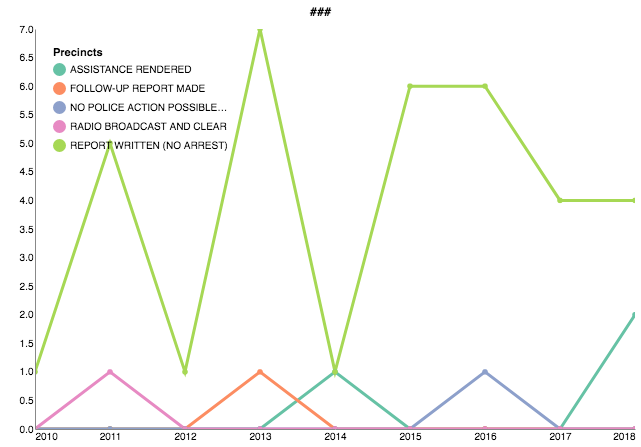

In [87]:
# USE
# Chart number of calls reporting each final call type

alt.Chart(data_tru_df).mark_line(point=True).encode(
    x=alt.X('year',axis=alt.Axis(format='Y', title='', ticks=False)),
    y=alt.Y('Molesting', axis=alt.Axis(title='', ticks=False)),
#     tooltip=('precinct', 'year','lewd_conduct'),
    color=alt.Color(
        'event_clearing',
        legend=alt.Legend(
            title='Precincts',
            orient='top-left'
        ), scale=alt.Scale(
            scheme='set2'
        ))
).properties(
    title='###',
    width=600,
    height=400
).configure_axis(
    grid=False
).configure_line(
    strokeWidth=3
).configure_view(
    strokeWidth=0
).interactive()

# To do: edit tooltips to remove labels and add "calls" after count. Change axis font label formatting

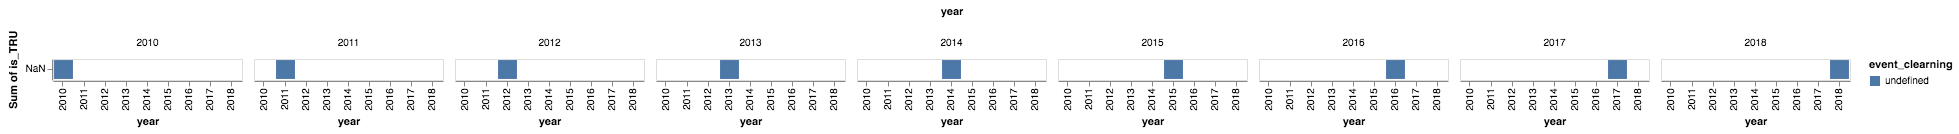

In [66]:

alt.Chart(data_tru_df).mark_bar().encode(
    x='year:O',
    y='sum(is_TRU)',
    color='event_clearning:N',
    column='year:N'
)


In [75]:
data_tru_df = data_tru_df.groupby('event_clearing')
# lewd_call_total_df = lewd_call_total_df.stack().reset_index()
# lewd_call_total_df = lewd_call_total_df.rename(columns={0: 'type_count'})
data_tru_df.head()

AttributeError: Cannot access callable attribute 'groupby' of 'DataFrameGroupBy' objects, try using the 'apply' method

## 4. Lewd Calls

Demonstrate the connections between the amount of time between when the call was taken and when the first officer arrived on scene and the call outcome.

In [36]:
# Create df for all in progress lewd calls with bad arrived_time rows removed
# total i/p lewd calls = 5673

lewd_calls_ip = data[data.arrived_time > '1900-1-1']
lewd_calls_ip = lewd_calls_ip[lewd_calls_ip.final_call_type.str.contains("LEWD")]
lewd_calls_ip = lewd_calls_ip[lewd_calls_ip.priority <= 3]

In [37]:
# View count of clearing codes
# lewd_calls_ip.event_clearing.value_counts()

In [38]:
# Refine df to only include the 5 most common clearing codes
# 90% of all calls were cleared with one of these clearing calls

top_lewd_cc_terms = 'REPORT WRITTEN|ASSISTANCE RENDERED|PHYSICAL ARREST|UNABLE TO LOCATE|ORAL WARNING'
lewd_calls_ip = lewd_calls_ip[lewd_calls_ip.event_clearing.str.contains(top_lewd_cc_terms)]